In [1]:
import pandas as pd

from rmexp import schema
from rmexp.utilityfunc import app_default_utility_func


In [2]:
df = pd.read_sql("select * from ExpLatency", schema.engine).drop(['id', 'date'], axis=1)
df['per_frame_util'] = df.apply(
    lambda r: app_default_utility_func[r['app']](r['reply']),
    axis=1
)
df['index_int'] = df['index'].astype(int)
df.head(20)

,name,index,val,app,client,arrival,finished,reply,per_frame_util,index_int
0,lego1-ours,1,None,lego,0,11,192,193,1.0,1
1,lego1-ours,3,None,lego,0,11,202,224,1.0,3
2,lego1-ours,10,None,lego,0,16,196,197,1.0,10
3,lego1-ours,11,None,lego,0,15,197,222,1.0,11
4,lego1-ours,17,None,lego,0,18,110,111,1.0,17
5,lego1-ours,18,None,lego,0,16,131,132,1.0,18
6,lego1-ours,21,None,lego,0,12,199,200,1.0,21
7,lego1-ours,23,None,lego,0,16,175,186,1.0,23
8,lego1-ours,28,None,lego,0,19,147,148,1.0,28
9,lego1-ours,29,None,lego,0,17,138,149,1.0,29


In [3]:
util_summary = df.groupby(['name', 'app']).agg('mean')
util_summary.head(30)

arrival     finished  \
name                              app                                 
face4-baseline                    face       51.571823   406.327348   
face4-ours                        face       49.473720   399.333558   
face4pool4-baseline               face      397.745849   834.413793   
                                  pool      513.913621  1098.167774   
face4pool4-ours                   pool       29.138679    86.513208   
face4pool4pingpong4-baseline      face      690.248971  1384.977366   
                                  pingpong  214.150651   498.696254   
                                  pool      850.505291  1779.917989   
face4pool4pingpong4-ours          pingpong   19.522544    58.291884   
face4pool4pingpong4lego4-baseline face      304.613037   730.804438   
                                  lego      274.804348   660.222826   
                                  pingpong  239.324324   568.567568   
                                  pool      556.379747  1192.367089   
face4pool4pingpong4lego4-ours     lego       54.515449   143.802669   
                                  pingpong   29.192771    79.979920   
lego1-baseline                    lego       14.964768   104.601949   
lego1-ours                        lego       14.374106   100.122318   
lego1pingpong1-baseline           lego       13.800454    83.238851   
                                  pingpong   15.279734   114.447193   
lego1pingpong1-ours               lego       13.525532    81.156028   
                                  pingpong   14.748168   110.527473   
lego1pingpong1face1-baseline      face       16.841328   291.409594   
                                  lego       17.239289   143.088819   
                                  pingpong   17.216080   253.351759   
lego1pingpong1face1-ours          face       17.669468   462.689076   
                                  lego       14.847584   127.118959   
                                  pingpong   16.163782   195.872170   
lego1pingpong1face1pool1-baseline face       16.729216   382.973872   
                                  lego       17.401907   197.020436   
                                  pingpong   18.261682   371.976636   

                                                  reply  per_frame_util  \
name                              app                                     
face4-baseline                    face       412.772790    9.862203e-01   
face4-ours                        face       405.400943    9.878123e-01   
face4pool4-baseline               face       839.370370    8.673135e-01   
                                  pool      1102.533223    1.757384e-41   
face4pool4-ours                   pool        95.285849    7.862580e-01   
face4pool4pingpong4-baseline      face      1389.936214    3.950938e-01   
                                  pingpong   505.638436    1.390966e-01   
                                  pool      1784.235450    6.024550e-96   
face4pool4pingpong4-ours          pingpong    74.877551    9.995202e-01   
face4pool4pingpong4lego4-baseline face       735.564494    8.913539e-01   
                                  lego       667.798913    9.723176e-01   
                                  pingpong   577.290541    2.537936e-01   
                                  pool      1198.555154    1.166173e-63   
face4pool4pingpong4lego4-ours     lego       158.254213    9.999999e-01   
                                  pingpong    90.988956    9.837560e-01   
lego1-baseline                    lego       107.965517    9.999984e-01   
lego1-ours                        lego       103.368383    9.999987e-01   
lego1pingpong1-baseline           lego        89.204837    9.999901e-01   
                                  pingpong   120.870599    8.826466e-01   
lego1pingpong1-ours               lego        86.746099    9.999616e-01   
                                  pingpong   116.413004    8.901044e-01   
lego1pingpong1face1-baseline      face       293.

In [4]:
import matplotlib
rc_fonts = {
    "font.weight": 800,
    "font.family": "serif",
    "font.serif": ["Times"], # use latex's default
    "font.sans-serif": ["DejaVu Sans"],
    "text.usetex": True,
}
matplotlib.rcParams.update(rc_fonts)

In [5]:
baseline_total_utilities = []
ours_total_utilities = []
experiments = ['face4', 'face4pool4', 'face4pool4pingpong4', 'face4pool4pingpong4lego4']
apps = ['lego', 'pingpong', 'face', 'pool']

BASELINE = 0
OURS = 1

utilities = {
    app: {
        experiment: [0, 0]
        for experiment in experiments
    }
    for app in apps
}

for experiment in experiments:
    baseline_df = df.loc[df['name'] == '{}-baseline'.format(experiment)]
    ours_df = df.loc[df['name'] == '{}-ours'.format(experiment)]
    
    baseline_total_utility = 0
    ours_total_utility = 0
    
    for app in apps:
        baseline_app_df = baseline_df.loc[baseline_df.app == app]
        ours_app_df = ours_df.loc[ours_df.app == app]
    
        if (baseline_app_df.shape[0] > 0 and ours_app_df.shape[0] > 0):
            max_index_baseline_app = baseline_app_df.index_int.max()
            max_index_ours_app = ours_app_df.index_int.max()
            max_index_app = min(max_index_baseline_app, max_index_ours_app)

            valid_baseline_app_df = baseline_app_df[baseline_app_df.index_int < max_index_app]
            valid_ours_app_df = ours_app_df[ours_app_df.index_int < max_index_app]

            baseline_app_utility = valid_baseline_app_df.per_frame_util.sum()
            ours_app_utility = valid_ours_app_df.per_frame_util.sum()
        else:
            baseline_app_utility = 0
            ours_app_utility = 0
    
        utilities[app][experiment][BASELINE] = baseline_app_utility
        utilities[app][experiment][OURS] = ours_app_utility
        
        baseline_total_utility += baseline_app_utility
        ours_total_utility += ours_app_utility
    
    baseline_total_utilities.append(baseline_total_utility)
    ours_total_utilities.append(ours_total_utility)

<IPython.core.display.Javascript object>


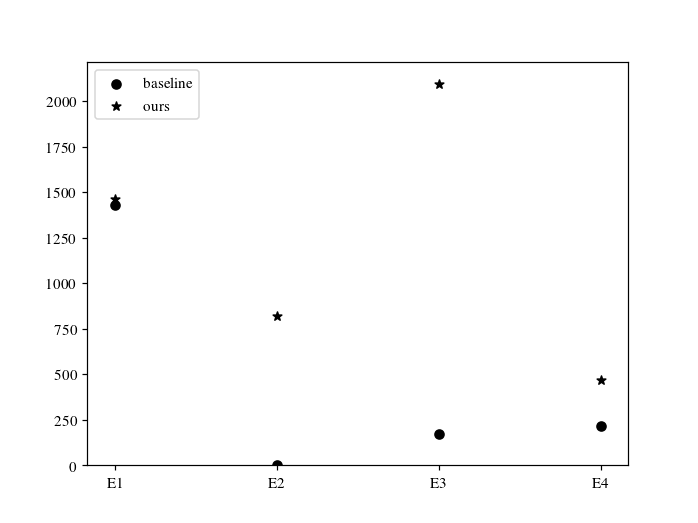

[1427.0470495078607, 1.0579449989461642e-38, 170.81064721904326, 214.48084919948576]
[1464.9134845479407, 818.5334889230311, 2094.989103886719, 466.548883337525]


In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)

AXIS_TITLES = ['E1', 'E2', 'E3', 'E4']

print(baseline_total_utilities)
print(ours_total_utilities)
ax1.scatter(AXIS_TITLES, baseline_total_utilities, color='k', marker='o', label='baseline')
ax1.scatter(AXIS_TITLES, ours_total_utilities, color='k', marker='*', label='ours')
ax1.set_ylim(ymin=0)
plt.legend(loc='upper left')
plt.show()
plt.savefig('total-utilities.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


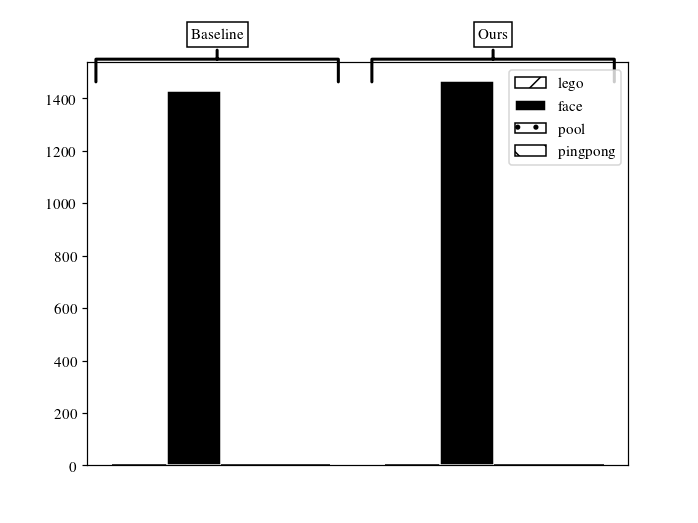

<IPython.core.display.Javascript object>


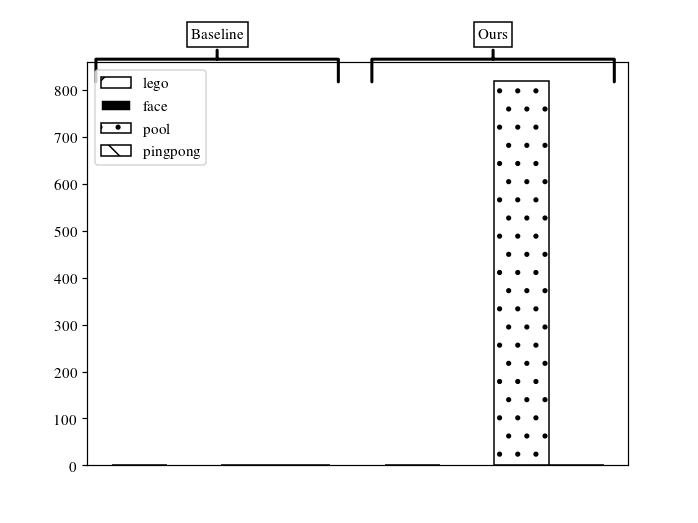

<IPython.core.display.Javascript object>


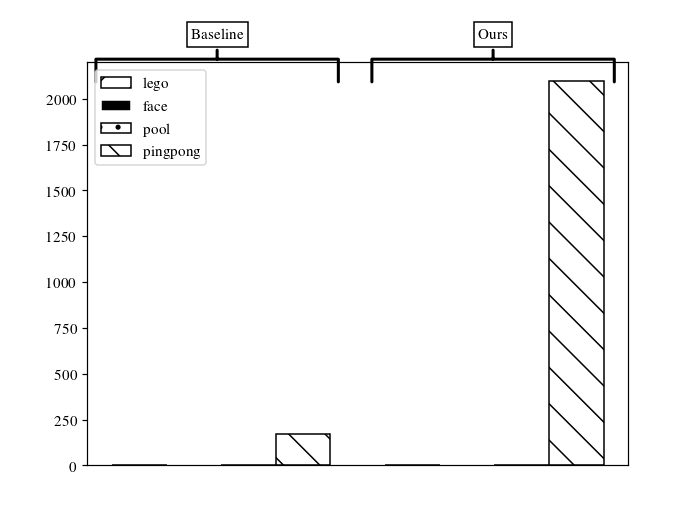

<IPython.core.display.Javascript object>


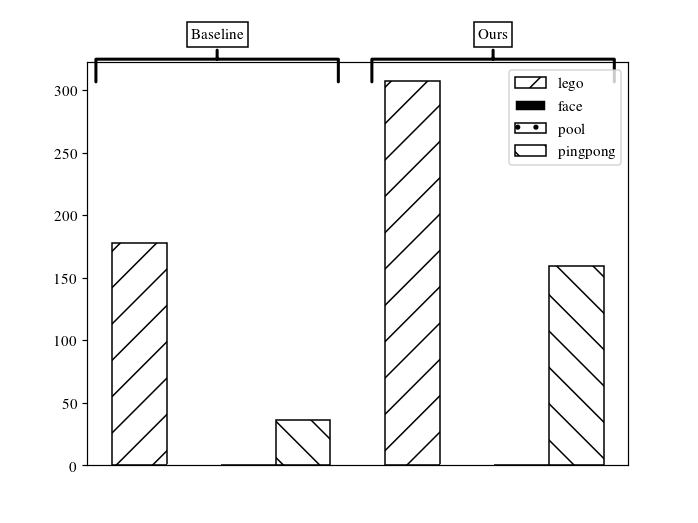

In [7]:
for experiment in experiments:
    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.bar([0, 1], utilities['lego'][experiment], width=0.2, color='w', edgecolor='k', hatch='/', align='center', label='lego')
    ax.bar([0.2, 1.2], utilities['face'][experiment], width=0.2, color='k', edgecolor='w', align='center', label='face')
    ax.bar([0.4, 1.4], utilities['pool'][experiment], width=0.2, color='w', edgecolor='k', hatch='.', align='center', label='pool')
    ax.bar([0.6, 1.6], utilities['pingpong'][experiment], width=0.2, color='w', edgecolor='k', hatch='\\', align='center', label='pingpong')
    
    # https://stackoverflow.com/a/35322778/859277
    ax.annotate('Baseline', xy=(0.24, 1.00), xytext=(0.24, 1.05), xycoords='axes fraction', 
            ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=8, lengthB=1.5', lw=2.0))
    ax.annotate('Ours', xy=(0.75, 1.00), xytext=(0.75, 1.05), xycoords='axes fraction', 
            ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=8, lengthB=1.5', lw=2.0))
    ax.axes.get_xaxis().set_visible(False)

    plt.legend()
    plt.show()
    plt.savefig('utility-{}.pdf'.format(experiment), bbox_inches='tight')

In [182]:
df.loc[df['app'] == 'pool'].per_frame_util.sum()

188.41249037027762

In [161]:
df.loc[(df['name'] == 'lego1pingpong1face1-ours') & (df['app'] == 'lego')].per_frame_util.sum()

1075.4949020380327

In [177]:
for experiment in experiments:
    baseline_df = df.loc[df['name'] == '{}-baseline'.format(experiment)]
    ours_df = df.loc[df['name'] == '{}-ours'.format(experiment)]    
    for app in apps:
        proccessed_baseline = 0
        skipped_baseline = 0        
        
        proccessed_ours = 0
        skipped_ours = 0
        
        baseline_app_df = baseline_df.loc[baseline_df.app == app]
        ours_app_df = ours_df.loc[ours_df.app == app]        
        
        if (baseline_app_df.shape[0] > 0 and ours_app_df.shape[0] > 0):
            max_index_baseline_app = baseline_app_df.index_int.max()
            max_index_ours_app = ours_app_df.index_int.max()
            max_index_app = min(max_index_baseline_app, max_index_ours_app)
            
            max_index_baseline_app_index_values = baseline_app_df.index_int.values
            max_index_ours_app_index_values = ours_app_df.index_int.values

            for i in xrange(max_index_app):
                if i in max_index_baseline_app_index_values:
                    proccessed_baseline += 1
                else:
                    skipped_baseline += 1
                    
                if i in max_index_ours_app_index_values:
                    proccessed_ours += 1
                else:
                    skipped_ours += 1
            print experiment, app, 'baseline'
            print 'processed:', proccessed_baseline, 'skipped:', skipped_baseline
            print ''
            print experiment, app, 'ours'
            print 'processed:', proccessed_ours, 'skipped:', skipped_ours
            print ''

lego2 lego baseline
processed: 1279 skipped: 1419

lego2 lego ours
processed: 1331 skipped: 1367

lego2face2 lego baseline
processed: 977 skipped: 1719

lego2face2 lego ours
processed: 1079 skipped: 1617

lego2face2 face baseline
processed: 794 skipped: 1897

lego2face2 face ours
processed: 739 skipped: 1952

lego2face2pool2 lego baseline
processed: 681 skipped: 2008

lego2face2pool2 lego ours
processed: 959 skipped: 1730

lego2face2pool2 face baseline
processed: 518 skipped: 2171

lego2face2pool2 face ours
processed: 687 skipped: 2002

lego2face2pool2 pool baseline
processed: 367 skipped: 2082

lego2face2pool2 pool ours
processed: 24 skipped: 2425

lego2pingpong2face2pool2 lego baseline
processed: 507 skipped: 2185

lego2pingpong2face2pool2 lego ours
processed: 1181 skipped: 1511

lego2pingpong2face2pool2 pingpong baseline
processed: 376 skipped: 2274

lego2pingpong2face2pool2 pingpong ours
processed: 719 skipped: 1931

lego2pingpong2face2pool2 pool baseline
processed: 257 skipped: 19

In [183]:
utilities['pool']['lego2pingpong2face2pool2']

[2.3109513872765699e-21, 0.0]